In [1]:
import os
from pathlib import Path
import random

import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Path to the dataset (relative to the notebook)
DATA_ROOT = Path("../data")
MACHINE_TYPES = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

# Audio and feature configuration
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# (voor proxy-outlier gaan we vaak met volledige spectrogrammen werken, maar
# het is prima om deze patch-config ook alvast klaar te hebben voor evt. sliding windows)
PATCH_FRAMES = 64
PATCH_HOP = 32

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device("cuda")
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device("cpu")

print("Using device:", device)


PyTorch version: 2.9.1+cu126
CUDA available: True
Number of CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU
Using device: cuda


In [2]:
def scan_files(data_root=DATA_ROOT, machine_types=None):
    """
    Scan ../data and return a list of dictionaries:
        {
            'path': Path,
            'machine_type': str,
            'split': 'train' or 'test',
            'label': 0 (normal) or 1 (anomaly)
        }

    Deze structuur is hetzelfde als in de IDC-TransAE notebook,
    zodat je file_list in beide experimenten uitwisselbaar is.
    """
    if machine_types is None:
        machine_types = MACHINE_TYPES

    all_files = []

    for mtype in machine_types:
        for split in ["train", "test"]:
            split_dir = data_root / mtype / split
            if not split_dir.exists():
                continue

            for fname in sorted(split_dir.glob("*.wav")):
                name_lower = fname.name.lower()

                if "normal" in name_lower:
                    label = 0
                elif "anomaly" in name_lower:
                    label = 1
                else:
                    # fallback als de bestandsnaam geen expliciet label bevat
                    label = None

                all_files.append({
                    "path": fname,
                    "machine_type": mtype,
                    "split": split,
                    "label": label,
                })

    return all_files


file_list = scan_files()
print(len(file_list))
file_list[:5]


30987


[{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0},
 {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
  'machine_type': 'fan',
  'split': 'train',
  'label': 0}]

In [3]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file as mono at a fixed sample rate.

    Returns:
        audio: np.ndarray, shape (samples,)
        sr   : int, sample rate
    """
    audio, sr = librosa.load(path, sr=sr, mono=True)
    return audio, sr


def audio_to_logmelspec(
    audio,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert a waveform into a log-Mel spectrogram.
    audio : 1D numpy array
    sr    : sample rate

    Returns:
        log-Mel spectrogram of shape (n_mels, n_frames)
    """
    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )

    logS = np.log(S + 1e-12)
    return logS


In [4]:
def build_target_vs_po_lists(file_list, target_type):
    """
    Bouw twee lijsten:
        target_train : alle NORMAL train samples van target machine
        po_train     : alle NORMAL train samples van alle andere machines

    Voor evaluatie:
        target_test_normal
        target_test_anomaly

    Returns dictionary met 4 lijsten.
    """
    target_train = []
    po_train = []
    target_test_normal = []
    target_test_anomaly = []

    for entry in file_list:
        m = entry["machine_type"]
        split = entry["split"]
        label = entry["label"]

        # Train splits
        if split == "train":
            if m == target_type and label == 0:
                target_train.append(entry)
            elif m != target_type and label == 0:
                po_train.append(entry)

        # Test splits for final evaluation
        elif split == "test":
            if m == target_type:
                if label == 0:
                    target_test_normal.append(entry)
                elif label == 1:
                    target_test_anomaly.append(entry)

    return {
        "target_train": target_train,
        "po_train": po_train,
        "target_test_normal": target_test_normal,
        "target_test_anomaly": target_test_anomaly,
    }


In [5]:
splits = build_target_vs_po_lists(file_list, target_type="fan")
for k, v in splits.items():
    print(k, len(v))


target_train 3675
po_train 16444
target_test_normal 400
target_test_anomaly 1475


In [6]:
class ProxyOUDataset(Dataset):
    """
    Binaire classificatie:
        label=1 → target machine (normaal)
        label=0 → proxy outlier (andere machines / andere bron)
    entries: list van dicts uit scan_files()
    """

    def __init__(self, entries, label, transform=None):
        self.entries = entries
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        path = item["path"]

        audio, sr = load_audio(path)
        spec = audio_to_logmelspec(audio, sr)   # (n_mels, n_frames)
        spec = torch.tensor(spec, dtype=torch.float32)

        # (C, H, W) = (1, n_mels, n_frames)
        spec = spec.unsqueeze(0)

        y = torch.tensor(self.label, dtype=torch.long)

        if self.transform is not None:
            spec = self.transform(spec)

        return spec, y

In [7]:
splits_debug = {
    "target_train": [f for f in file_list if f["machine_type"] == "fan" and f["split"] == "train" and f["label"] == 0][:5],
    "po_train":     [f for f in file_list if f["machine_type"] != "fan" and f["split"] == "train" and f["label"] == 0][:5],
}

ds_debug = ProxyOUDataset(splits_debug["target_train"], label=1)
x, y = ds_debug[0]
print(x.shape, y)

torch.Size([1, 128, 313]) tensor(1)


In [8]:
def collate_spectrogram_batch(batch):
    """
    Pad alle spectrogrammen in de batch rechts met nullen zodat
    ze dezelfde tijd-dimensie (n_frames) hebben.

    batch: list of (spec, label), waarbij
           spec: [1, n_mels, T_i]
           label: scalar tensor
    return:
           x: [B, 1, n_mels, T_max]
           y: [B]
    """
    specs, labels = zip(*batch)  # tuples van tensors

    # Bepaal maximale lengte in deze batch
    widths = [s.shape[-1] for s in specs]
    max_w = max(widths)

    batch_size = len(specs)
    # Init met nullen
    x = torch.zeros(batch_size, 1, N_MELS, max_w, dtype=specs[0].dtype)

    for i, s in enumerate(specs):
        T = s.shape[-1]
        x[i, :, :, :T] = s  # vul tot eigen lengte

    y = torch.stack(labels, dim=0)

    return x, y


In [9]:
# Klein testje met een handgemaakte "batch"
a = torch.randn(1, N_MELS, 313)
b = torch.randn(1, N_MELS, 344)

xb, yb = collate_spectrogram_batch([(a, torch.tensor(1)), (b, torch.tensor(0))])
print(xb.shape, yb.shape)

torch.Size([2, 1, 128, 344]) torch.Size([2])


In [10]:
def build_target_vs_po_lists(file_list, target_type, po_strategy="other_types"):
    """
    Bouw 4 lijsten voor één target machine type:
      - target_train: normale train samples van target_type
      - po_train    : proxy outliers (afhankelijk van po_strategy)
      - target_test_normal
      - target_test_anomaly

    po_strategy:
      - "other_types": alle NORMAL train samples van andere machine types
      - "all": alle train samples die NIET target_type zijn (normal + anomaly)
    """
    target_train = []
    po_train = []
    target_test_normal = []
    target_test_anomaly = []

    for entry in file_list:
        m = entry["machine_type"]
        split = entry["split"]
        label = entry["label"]

        # Train
        if split == "train":
            if m == target_type and label == 0:
                target_train.append(entry)
            elif m != target_type:
                if po_strategy == "other_types":
                    if label == 0:
                        po_train.append(entry)
                elif po_strategy == "all":
                    # gebruik alles als proxy (normal + anomaly) voor niet-target
                    po_train.append(entry)

        # Test (alleen target machine)
        elif split == "test" and m == target_type:
            if label == 0:
                target_test_normal.append(entry)
            elif label == 1:
                target_test_anomaly.append(entry)

    return {
        "target_train": target_train,
        "po_train": po_train,
        "target_test_normal": target_test_normal,
        "target_test_anomaly": target_test_anomaly,
    }


In [11]:
splits_fan = build_target_vs_po_lists(file_list, target_type="fan", po_strategy="other_types")
for k, v in splits_fan.items():
    print(k, len(v))


target_train 3675
po_train 16444
target_test_normal 400
target_test_anomaly 1475


In [12]:
class DcaseLikeCNN(nn.Module):
    """
    Eenvoudige maar sterkere CNN:
    - 4 conv-blokken met BatchNorm + MaxPool
    - AdaptiveAvgPool -> vaste feature size
    - 2-layer MLP naar 2 logits
    """

    def __init__(self, n_classes=2):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),  # output: [B, 256, 4, 4]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [13]:
model = DcaseLikeCNN().to(device)
dummy = torch.randn(2, 1, N_MELS, 300).to(device)
out = model(dummy)
print(out.shape)  # verwacht: [2, 2]


torch.Size([2, 2])


In [14]:
from torch.utils.data import ConcatDataset, WeightedRandomSampler

def make_proxy_dataloaders(
    splits,
    batch_size=16,
    shuffle_test=False,
):
    """
    Maakt train_loader + test_loader voor één target machine type.

    Train:
      - dataset = target_train (label=1) + po_train (label=0)
      - balanced sampling d.m.v. WeightedRandomSampler

    Test:
      - dataset = target_test_normal (label=1) + target_test_anomaly (label=0)
      - gewoon sequential, geen sampling
    """
    # Train
    target_train_ds = ProxyOUDataset(splits["target_train"], label=1)
    po_train_ds     = ProxyOUDataset(splits["po_train"], label=0)

    train_ds = ConcatDataset([target_train_ds, po_train_ds])

    num_target = len(target_train_ds)
    num_po     = len(po_train_ds)

    # weights per sample (in volgorde van ConcatDataset)
    weights = [1.0 / num_target] * num_target + [1.0 / num_po] * num_po
    sampler = WeightedRandomSampler(weights, num_samples=num_target + num_po, replacement=True)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        sampler=sampler,
        collate_fn=collate_spectrogram_batch,
    )

    # Test
    test_ds = ConcatDataset([
        ProxyOUDataset(splits["target_test_normal"], label=1),
        ProxyOUDataset(splits["target_test_anomaly"], label=0),
    ])

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=shuffle_test,
        collate_fn=collate_spectrogram_batch,
    )

    return train_loader, test_loader


In [15]:
train_loader_fan, test_loader_fan = make_proxy_dataloaders(splits_fan, batch_size=16)
xb, yb = next(iter(train_loader_fan))
print(xb.shape, yb.shape, yb.unique(return_counts=True))


torch.Size([16, 1, 128, 344]) torch.Size([16]) (tensor([0, 1]), tensor([8, 8]))


In [16]:
def train_proxy_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    count = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        count += x.size(0)

    return total_loss / count, correct / count


In [17]:
model_debug = DcaseLikeCNN().to(device)
opt_debug = torch.optim.Adam(model_debug.parameters(), lr=1e-3)

train_loss_debug, train_acc_debug = train_proxy_epoch(model_debug, train_loader_fan, opt_debug, device)
print("Train loss:", train_loss_debug, "acc:", train_acc_debug)


Train loss: 0.1845243265728736 acc: 0.9225607634574283


In [18]:
def eval_proxy_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    count = 0
    scores = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            count += x.size(0)

            probs = F.softmax(logits, dim=1)[:, 1]  # P(class=1 = target normal)
            scores.extend(probs.cpu().numpy())
            labels.extend(y.cpu().numpy())

    scores = np.array(scores)
    labels = np.array(labels)

    auc = metrics.roc_auc_score(labels, scores)
    return total_loss / count, correct / count, auc, scores, labels


In [19]:
val_loss_debug, val_acc_debug, val_auc_debug, scores_debug, labels_debug = eval_proxy_epoch(
    model_debug,
    test_loader_fan,
    device,
)
print("Val loss:", val_loss_debug, "acc:", val_acc_debug, "AUC:", val_auc_debug)


Val loss: 4.7016398668029655 acc: 0.232 AUC: 0.6964830508474577


In [20]:
def train_proxy_for_machine_type(
    file_list,
    target_type,
    po_strategy="other_types",
    num_epochs=10,
    lr=1e-3,
    batch_size=16,
    model_save_dir="proxy_models",
):
    os.makedirs(model_save_dir, exist_ok=True)

    print(f"\n=== Training proxy-outlier model voor '{target_type}' "
          f"(PO-strategy={po_strategy}) ===")

    splits = build_target_vs_po_lists(file_list, target_type, po_strategy=po_strategy)
    for k, v in splits.items():
        print(f"{k}: {len(v)}")

    train_loader, test_loader = make_proxy_dataloaders(splits, batch_size=batch_size)

    model = DcaseLikeCNN(n_classes=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_auc = -np.inf
    best_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_proxy_epoch(model, train_loader, optimizer, device)
        val_loss, val_acc, val_auc, _, _ = eval_proxy_epoch(model, test_loader, device)

        print(
            f"[{target_type} | Epoch {epoch:02d}] "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, val_auc={val_auc:.3f}"
        )

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {
                "model_state": model.state_dict(),
                "epoch": epoch,
                "val_auc": val_auc,
            }

    # Save best model
    ckpt_path = os.path.join(model_save_dir, f"proxy_{target_type}_{po_strategy}.pt")
    torch.save(best_state, ckpt_path)
    print(f"Beste model voor {target_type} opgeslagen naar {ckpt_path} (AUC={best_auc:.3f})")

    # Laatste eval (met best model)
    model.load_state_dict(best_state["model_state"])
    val_loss, val_acc, val_auc, scores, labels = eval_proxy_epoch(model, test_loader, device)

    result = {
        "target_type": target_type,
        "po_strategy": po_strategy,
        "ckpt_path": ckpt_path,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_auc": val_auc,
        "scores": scores,
        "labels": labels,
        "splits_counts": {k: len(v) for k, v in splits.items()},
    }
    return result


In [21]:
result_fan = train_proxy_for_machine_type(
    file_list,
    target_type="fan",
    po_strategy="other_types",
    num_epochs=5,
    lr=1e-3,
    batch_size=16,
)
result_fan["val_auc"], result_fan["val_acc"]



=== Training proxy-outlier model voor 'fan' (PO-strategy=other_types) ===
target_train: 3675
po_train: 16444
target_test_normal: 400
target_test_anomaly: 1475
[fan | Epoch 01] train_loss=0.1739, train_acc=0.928 | val_loss=9.4870, val_acc=0.215, val_auc=0.680
[fan | Epoch 02] train_loss=0.0623, train_acc=0.977 | val_loss=6.9687, val_acc=0.255, val_auc=0.723
[fan | Epoch 03] train_loss=0.0454, train_acc=0.984 | val_loss=2.9021, val_acc=0.471, val_auc=0.736
[fan | Epoch 04] train_loss=0.0294, train_acc=0.990 | val_loss=3.1509, val_acc=0.433, val_auc=0.751
[fan | Epoch 05] train_loss=0.0245, train_acc=0.991 | val_loss=5.0041, val_acc=0.384, val_auc=0.785
Beste model voor fan opgeslagen naar proxy_models\proxy_fan_other_types.pt (AUC=0.785)


(0.7850016949152542, 0.384)

In [22]:
import pandas as pd

def run_proxy_experiment_all_machines(
    file_list,
    machine_types=MACHINE_TYPES,
    po_strategy="other_types",
    num_epochs=10,
    lr=1e-3,
    batch_size=16,
):
    all_results = {}

    for mtype in machine_types:
        res = train_proxy_for_machine_type(
            file_list=file_list,
            target_type=mtype,
            po_strategy=po_strategy,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
        )
        all_results[mtype] = res

    # Compact overzicht
    summary = {
        mtype: {
            "po_strategy": res["po_strategy"],
            "val_auc": res["val_auc"],
            "val_acc": res["val_acc"],
            "train_target": res["splits_counts"]["target_train"],
            "train_po": res["splits_counts"]["po_train"],
            "test_normal": res["splits_counts"]["target_test_normal"],
            "test_anomaly": res["splits_counts"]["target_test_anomaly"],
        }
        for mtype, res in all_results.items()
    }

    df = pd.DataFrame.from_dict(summary, orient="index").sort_index()
    return all_results, df


In [23]:
all_results, summary_df = run_proxy_experiment_all_machines(
    file_list,
    machine_types=MACHINE_TYPES,
    po_strategy="other_types",
    num_epochs=3,
    lr=1e-3,
    batch_size=16,
)

display(summary_df)



=== Training proxy-outlier model voor 'fan' (PO-strategy=other_types) ===
target_train: 3675
po_train: 16444
target_test_normal: 400
target_test_anomaly: 1475
[fan | Epoch 01] train_loss=0.1758, train_acc=0.925 | val_loss=6.6172, val_acc=0.223, val_auc=0.716
[fan | Epoch 02] train_loss=0.0636, train_acc=0.977 | val_loss=8.5320, val_acc=0.228, val_auc=0.695
[fan | Epoch 03] train_loss=0.0419, train_acc=0.985 | val_loss=2.9753, val_acc=0.450, val_auc=0.707
Beste model voor fan opgeslagen naar proxy_models\proxy_fan_other_types.pt (AUC=0.716)

=== Training proxy-outlier model voor 'pump' (PO-strategy=other_types) ===
target_train: 3349
po_train: 16770
target_test_normal: 400
target_test_anomaly: 456
[pump | Epoch 01] train_loss=0.2416, train_acc=0.886 | val_loss=1.8816, val_acc=0.676, val_auc=0.746
[pump | Epoch 02] train_loss=0.0674, train_acc=0.975 | val_loss=3.4726, val_acc=0.604, val_auc=0.807
[pump | Epoch 03] train_loss=0.0469, train_acc=0.983 | val_loss=2.8220, val_acc=0.631, val_

,po_strategy,val_auc,val_acc,train_target,train_po,test_normal,test_anomaly
ToyCar,other_types,0.500000,0.569337,4000,16119,1400,1059
ToyConveyor,other_types,0.501446,0.683386,3000,17119,2399,1110
fan,other_types,0.706905,0.449600,3675,16444,400,1475
pump,other_types,0.752637,0.630841,3349,16770,400,456
slider,other_types,0.644426,0.366667,2804,17315,400,890
valve,other_types,0.616790,0.469852,3291,16828,400,479


In [24]:
from sklearn import metrics

def plot_roc_curves_all_machines(all_results, machine_types=MACHINE_TYPES):
    """
    Maakt een 2x3 grid met ROC-curves voor elk machine type.
    Gebruikt scores/labels uit all_results[mtype].
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.ravel()

    for ax, mtype in zip(axes, machine_types):
        res = all_results.get(mtype, None)
        if res is None or res.get("scores", None) is None:
            ax.axis("off")
            ax.set_title(f"{mtype} (geen data)")
            continue

        scores = res["scores"]
        labels = res["labels"]

        fpr, tpr, _ = metrics.roc_curve(labels, scores, pos_label=1)
        auc = res.get("val_auc", metrics.roc_auc_score(labels, scores))

        ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        ax.plot([0, 1], [0, 1], "--", label="random")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC – {mtype}")
        ax.grid(True)
        ax.legend(loc="lower right")

    # Als er minder dan 6 machine types zijn, resterende assen uitzetten
    for i in range(len(machine_types), len(axes)):
        axes[i].axis("off")

    fig.suptitle("Proxy Outlier – ROC-curves per machine type", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # type: ignore
    plt.show()


,po_strategy,val_auc,val_acc,train_target,train_po,test_normal,test_anomaly
ToyCar,other_types,0.500000,0.569337,4000,16119,1400,1059
ToyConveyor,other_types,0.501446,0.683386,3000,17119,2399,1110
fan,other_types,0.706905,0.449600,3675,16444,400,1475
pump,other_types,0.752637,0.630841,3349,16770,400,456
slider,other_types,0.644426,0.366667,2804,17315,400,890
valve,other_types,0.616790,0.469852,3291,16828,400,479


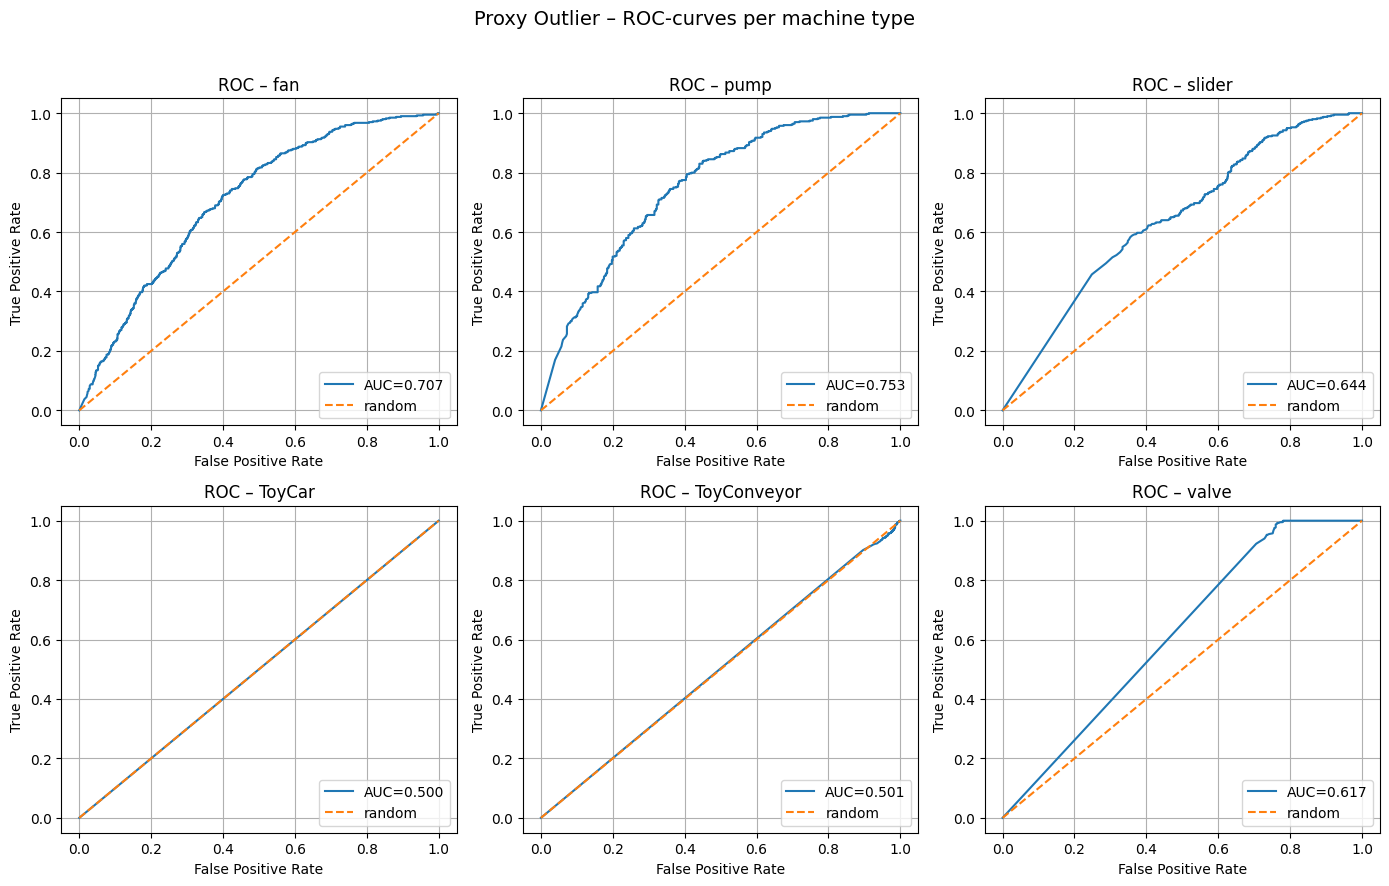

In [26]:
display(summary_df)
plot_roc_curves_all_machines(all_results, MACHINE_TYPES)

In [27]:
def plot_confusion_matrices_all_machines(
    all_results,
    machine_types=MACHINE_TYPES,
    threshold_mode="youden",   # "youden" of "fixed"
    fixed_threshold=0.5,
):
    """
    Plot 2x3 grid met confusion matrices per machine type.

    labels in je test:
      1 = normal (target)
      0 = anomaly
    We tonen dan rijen/kolommen als: [Anomaly, Normal].
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.ravel()
    im_last = None

    for ax, mtype in zip(axes, machine_types):
        res = all_results.get(mtype, None)
        if res is None or res.get("scores", None) is None:
            ax.axis("off")
            ax.set_title(f"{mtype} (geen data)")
            continue

        scores = res["scores"]
        labels = res["labels"]

        # Threshold kiezen
        if threshold_mode == "youden":
            fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
            j = tpr - fpr
            best_idx = np.argmax(j)
            thr = thresholds[best_idx]
        else:
            thr = fixed_threshold

        y_pred = (scores >= thr).astype(int)  # 1 = normal, 0 = anomaly

        cm = metrics.confusion_matrix(labels, y_pred, labels=[0, 1])
        # cm:
        #    [[TN_anomaly   FP_anomaly]
        #     [FN_normal    TP_normal]]

        im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
        im_last = im  # voor de colorbar later

        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Anomaly", "Normal"])
        ax.set_yticklabels(["Anomaly", "Normal"])
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")

        title = f"{mtype}\nthr={thr:.3f}"
        ax.set_title(title, fontsize=10)

        # Tekst in cellen
        max_val = cm.max() if cm.size > 0 else 1
        thresh_val = max_val / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j, i, int(cm[i, j]),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh_val else "black",
                )

    # Overgebleven assen (indien minder dan 6 types) uitzetten
    for i in range(len(machine_types), len(axes)):
        axes[i].axis("off")

    if im_last is not None:
        fig.colorbar(im_last, ax=axes.tolist(), fraction=0.02, pad=0.04)

    fig.suptitle(
        f"Proxy Outlier – Confusion matrices per machine type (threshold={threshold_mode})",
        fontsize=14,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_16924\2288498446.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


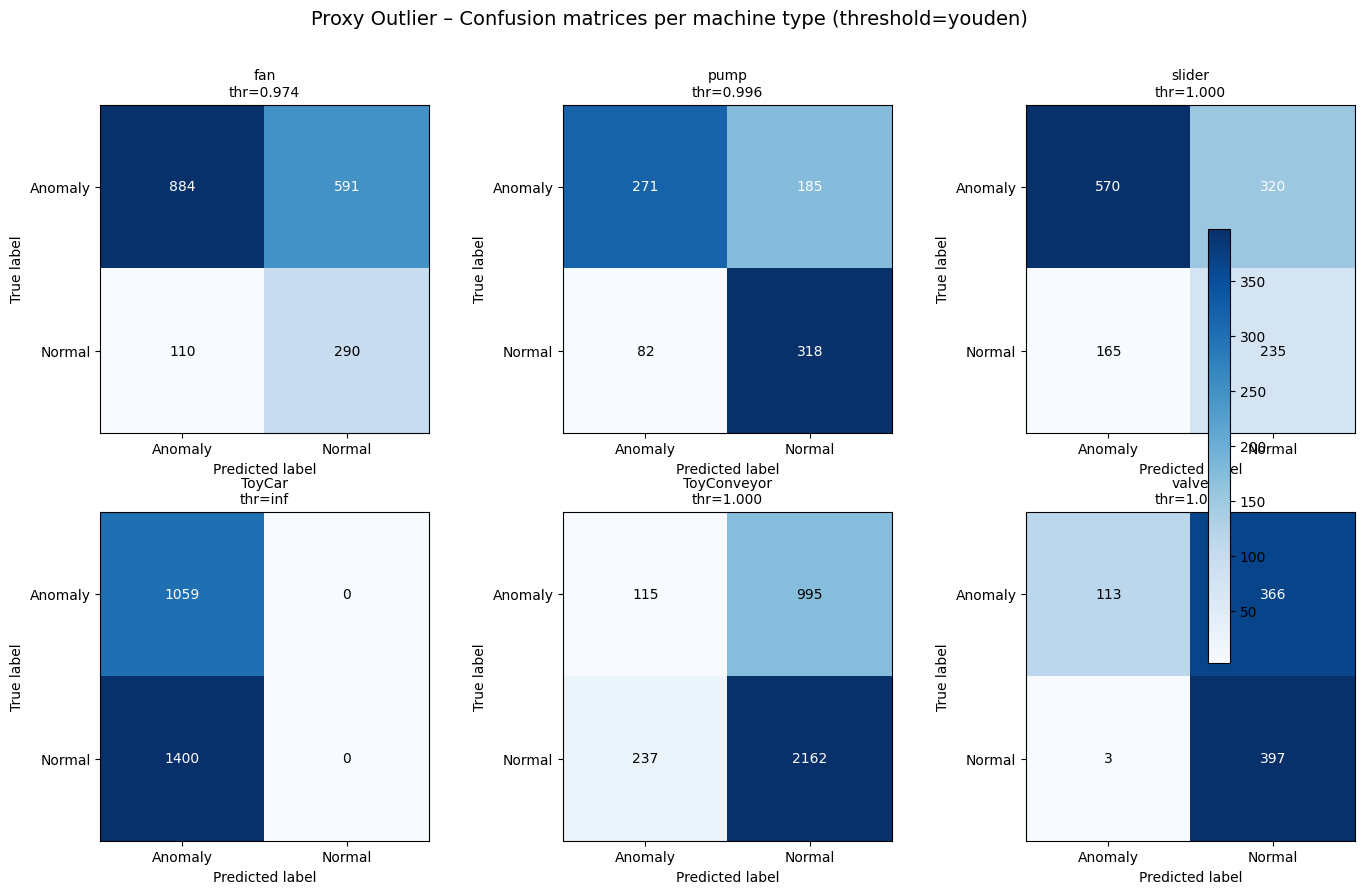

In [28]:
plot_confusion_matrices_all_machines(
    all_results,
    machine_types=MACHINE_TYPES,
    threshold_mode="youden",   # of "fixed"
    fixed_threshold=0.5,
)
